# Insurance Cross-selling Ranking Project
#### Proposed by [Sébastien Lozano-Forero](https://www.linkedin.com/in/sebastienlozanoforero/)
May, 2023. 

In [1]:
import sys
sys.path.append('C:\\Users\\Windows\\Desktop\\Repos\\insurance_prediction')

In [2]:
import os
import json
import shap
import boto3
import utils
import joblib
import pickle
import requests
import pandas as pd
import numpy  as np
import boruta as bt
import seaborn as sns
import scikitplot as skplt

from pathlib import Path
from dotenv import load_dotenv
from xgboost import XGBClassifier  
from sklearn import ensemble as en
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from ydata_profiling import ProfileReport
from sqlalchemy import create_engine, text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
print('[Info] Libraries imported successfully')

[Info] Libraries imported successfully


In [3]:
creds, _ = utils.load_credentials()

query = """
   SELECT * FROM insurance
   --limit 100
"""

df_raw = utils.getting_data_from_AWS_RDS(query = query,
                                         host = creds['host'],  
                                         port = creds['port'],  
                                         database = creds['database'], 
                                         user = creds['user'],
                                         password = creds['password'])

[Info] Data Frame with 762218 rows and 11 columns imported successfully.


# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['gender', 'age', 'driving_license', 'region_code', 'previously_insured',
       'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [6]:
df1.sample(5)

gender   age  driving_license  region_code  previously_insured  \
447248  Female  44.0              1.0         28.0                 0.0   
145153    Male  26.0              1.0         30.0                 1.0   
154817  Female  72.0              1.0         28.0                 1.0   
745686    Male  58.0              1.0         18.0                 0.0   
314408    Male  37.0              1.0         39.0                 1.0   

       vehicle_age vehicle_damage  annual_premium  policy_sales_channel  \
447248    1-2 Year            Yes          2630.0                 124.0   
145153    < 1 Year             No         28093.0                 152.0   
154817    1-2 Year             No         35053.0                 122.0   
745686   > 2 Years            Yes         27448.0                  26.0   
314408    1-2 Year             No          2630.0                 124.0   

        vintage  response  
447248     11.0       1.0  
145153    288.0       0.0  
154817     11.0       0.0  
745686    285.0       0.0  
314408     74.0       0.0

## 1.1. Data Dimension

In [7]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}')

Number of Rows: 762218
Number of Columns: 11


## 1.2. Data Types

In [8]:
df1.dtypes

gender                   object
age                     float64
driving_license         float64
region_code             float64
previously_insured      float64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                 float64
response                float64
dtype: object

In [9]:
df1['age'] = df1['age'].astype(int)
df1['driving_license'] = df1['driving_license'].astype(int)
df1['region_code'] = df1['region_code'].astype(int)
df1['previously_insured'] = df1['previously_insured'].astype(int)
df1['vintage'] = df1['vintage'].astype(int)
df1['response'] = df1['response'].astype(int)

In [10]:
df1.dtypes

gender                   object
age                       int32
driving_license           int32
region_code               int32
previously_insured        int32
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int32
response                  int32
dtype: object

## Target variable

In [11]:
df1['response'].value_counts()/df1['response'].shape[0]

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.3. Check NA

In [12]:
df1.isna().sum()

gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [13]:
profile = ProfileReport(df1, title="Profiling Report")

In [14]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
profile.to_file("EDA_aux.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
%matplotlib inline

In [17]:
utils.statistical_summary(dataframe = df1)

attributes     min       max     range          mean   median  \
0                   age    20.0      85.0      65.0     38.822584     36.0   
1       driving_license     0.0       1.0       1.0      0.997869      1.0   
2           region_code     0.0      52.0      52.0     26.388807     28.0   
3    previously_insured     0.0       1.0       1.0      0.458210      0.0   
4        annual_premium  2630.0  540165.0  537535.0  30564.389581  31669.0   
5  policy_sales_channel     1.0     163.0     162.0    112.034295    133.0   
6               vintage    10.0     299.0     289.0    154.347397    154.0   
7              response     0.0       1.0       1.0      0.122563      0.0   

            std       skew    kurtosis  
0     15.511591   0.672538   -0.565659  
1      0.046109 -21.595139  464.351248  
2     13.229871  -0.115266   -0.867859  
3      0.498251   0.167747   -1.971866  
4  17213.132474   1.766084   34.004338  
5     54.203924  -0.900006   -0.970812  
6     83.671194   0.003030   -1.200688  
7      0.327935   2.301901    3.298758

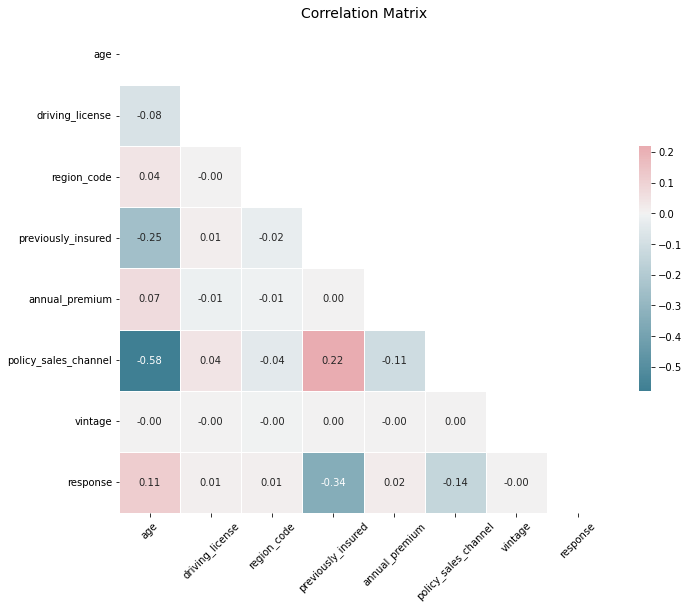

In [18]:
utils.correlation_matrix(dataframe = df1)

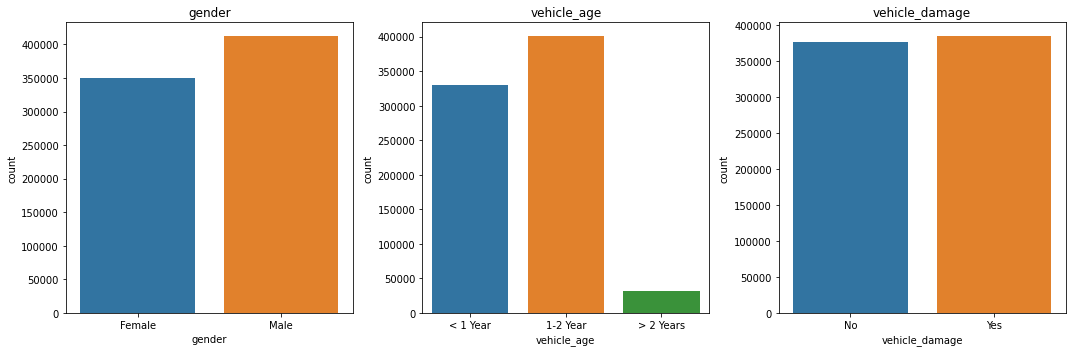

In [19]:
utils.plot_categorical_features(dataframe = df1)

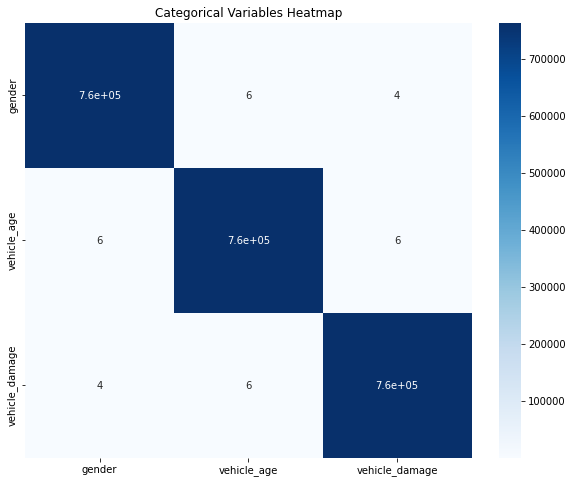

In [20]:
utils.plot_categorical_heatmap(dataframe = df1)

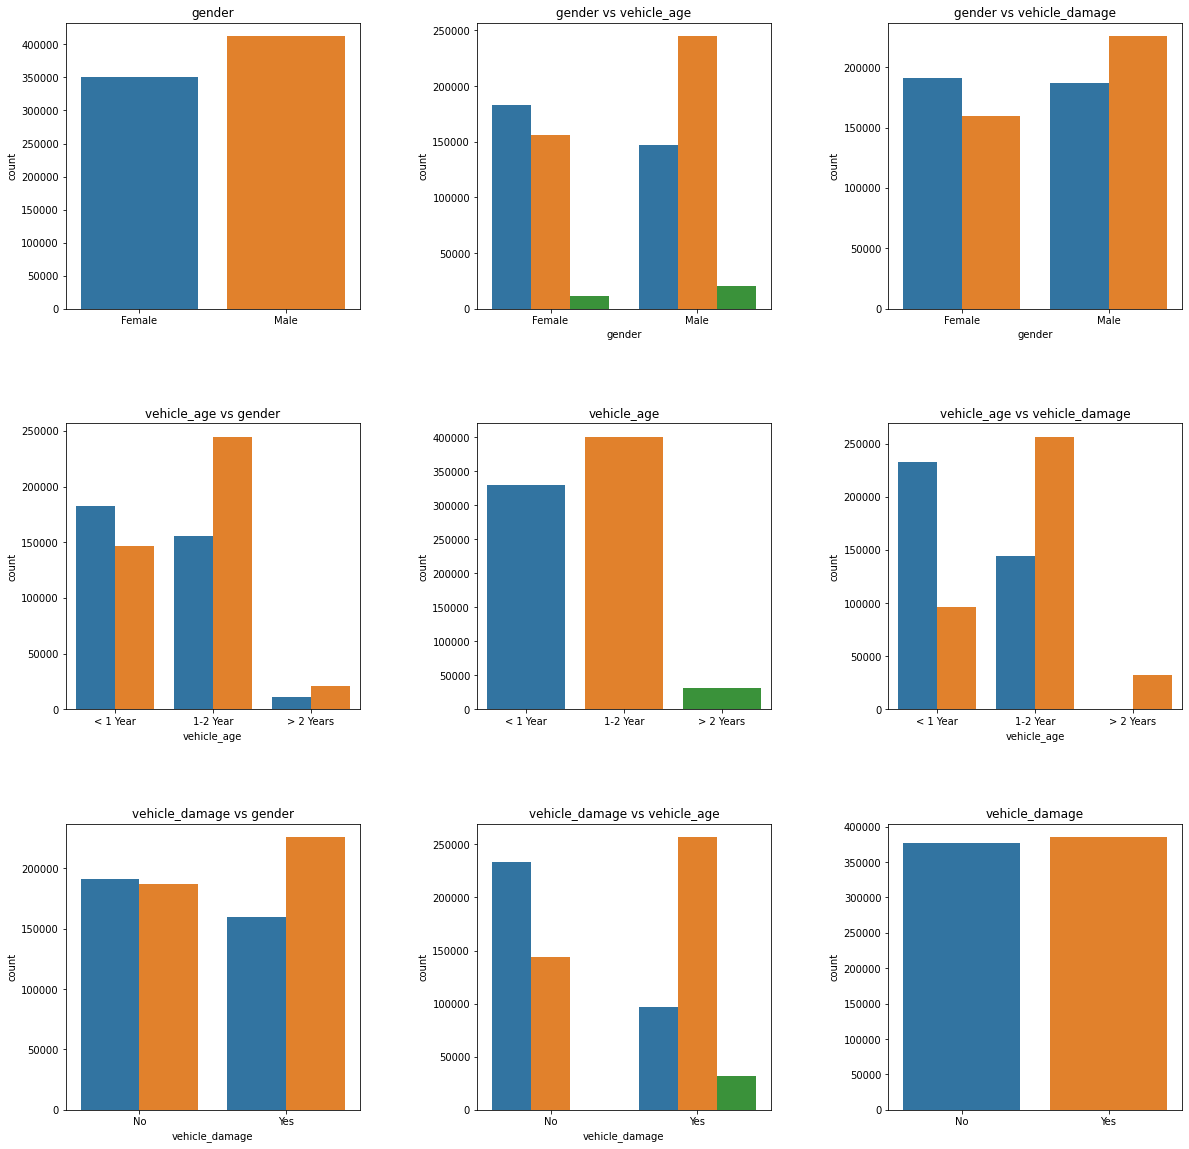

In [21]:
utils.plot_clustered_bars(dataframe = df1)

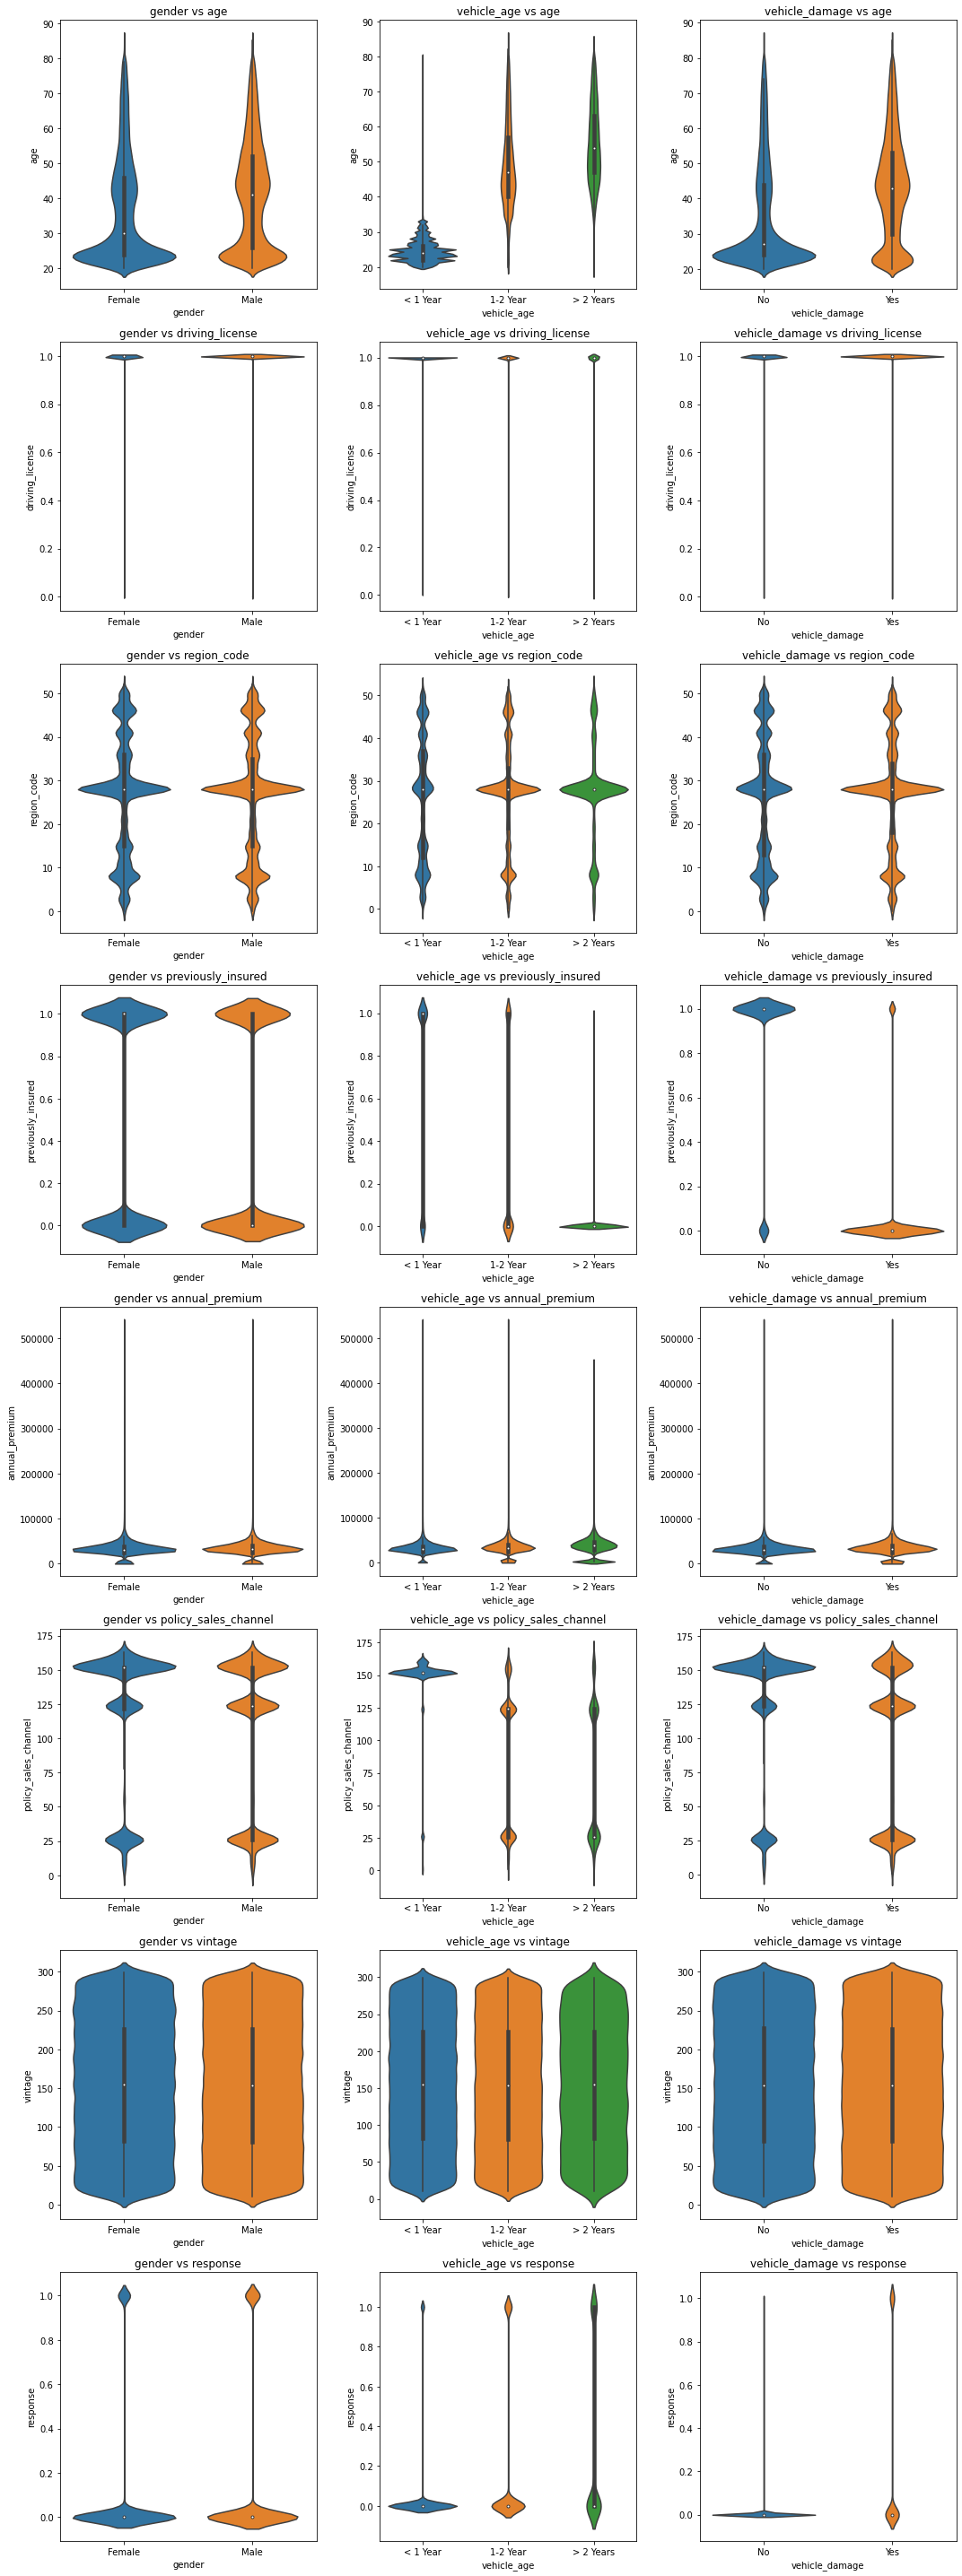

In [22]:
utils.plot_categorical_numerical_interactions(dataframe = df1)

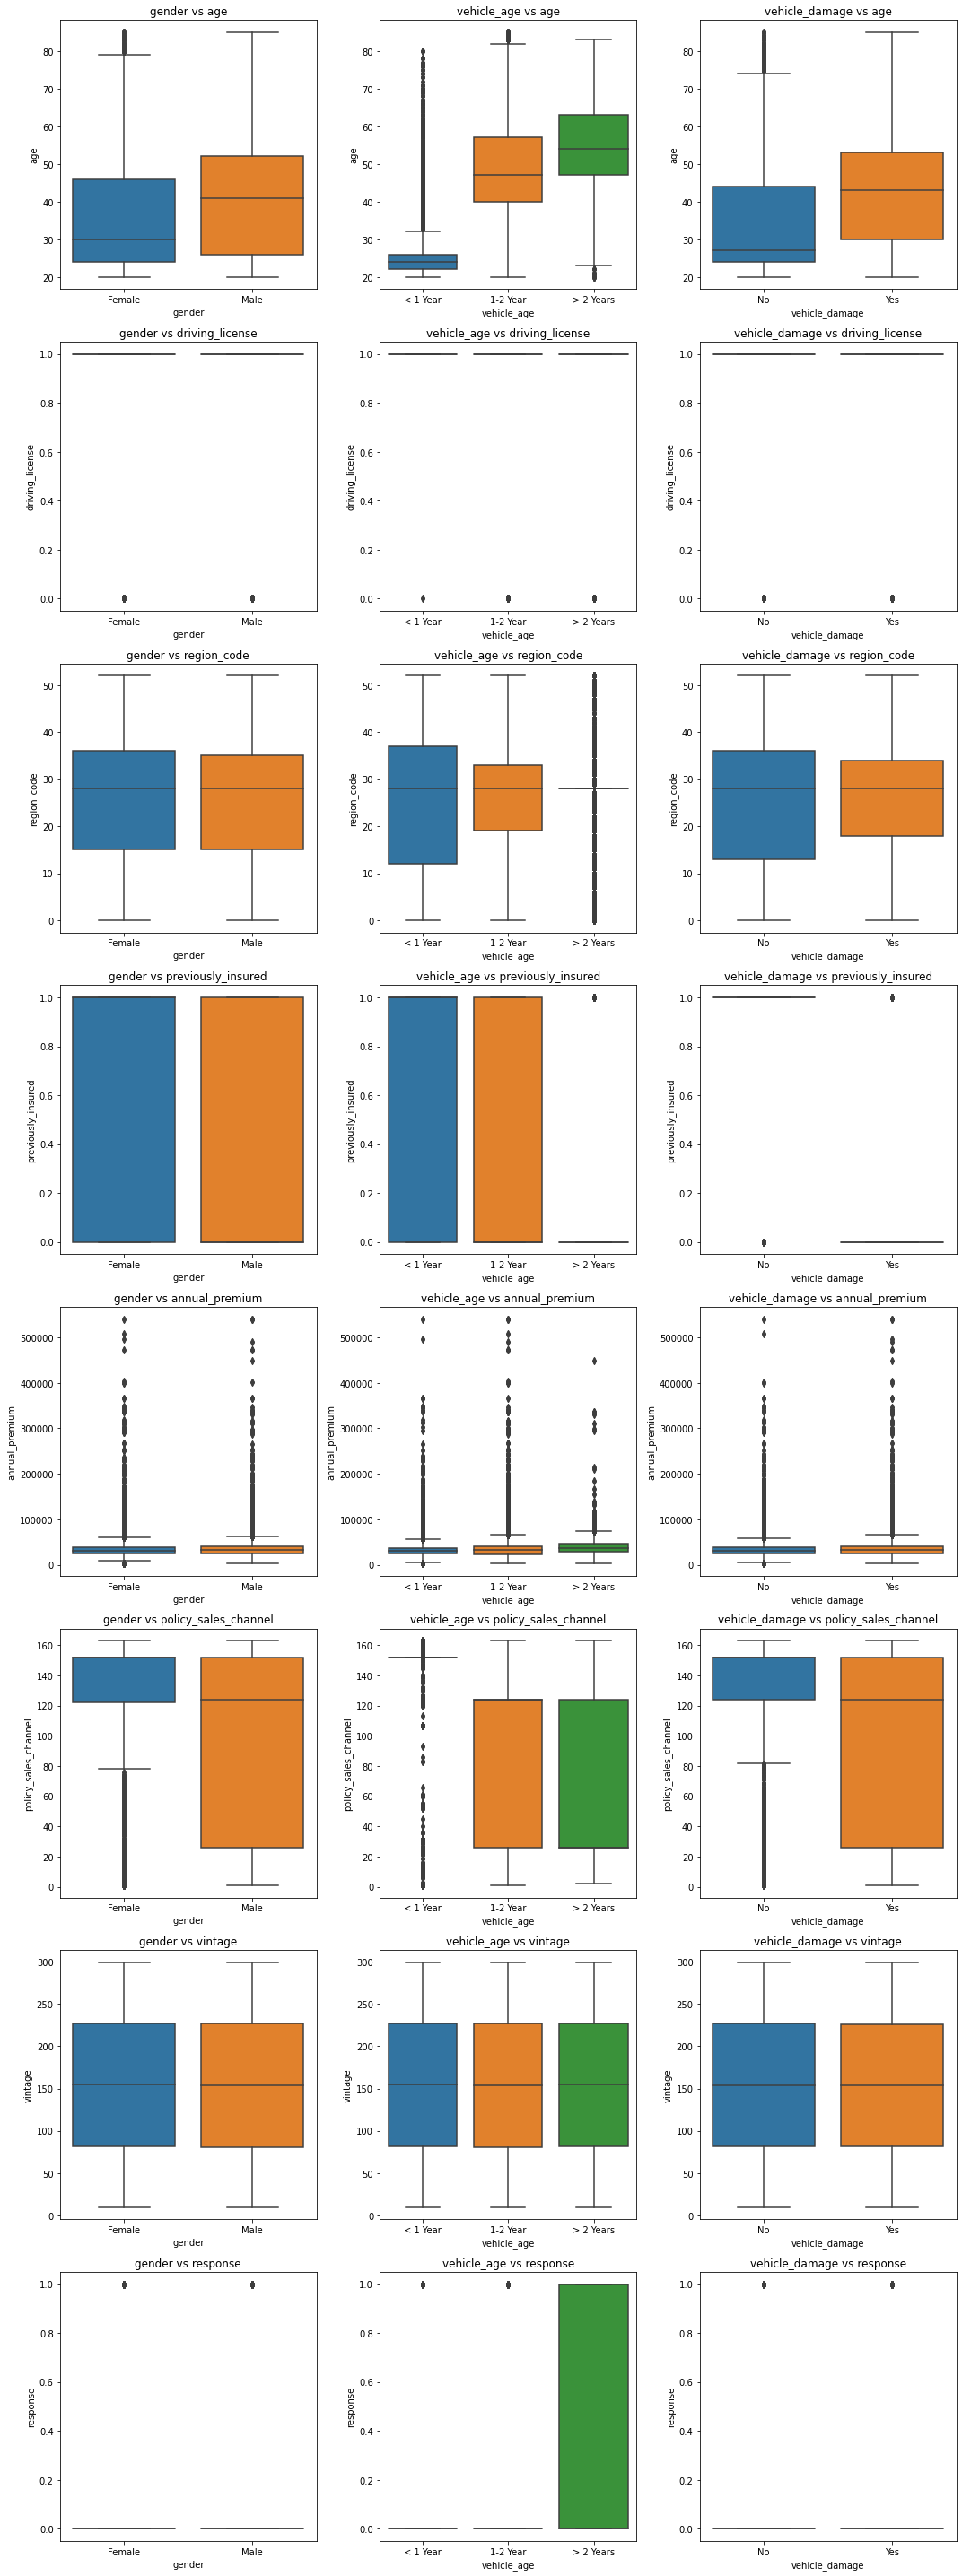

In [23]:
utils.plot_categorical_numerical_interactions(dataframe = df1, 
                                              plot_type = 'boxplot')

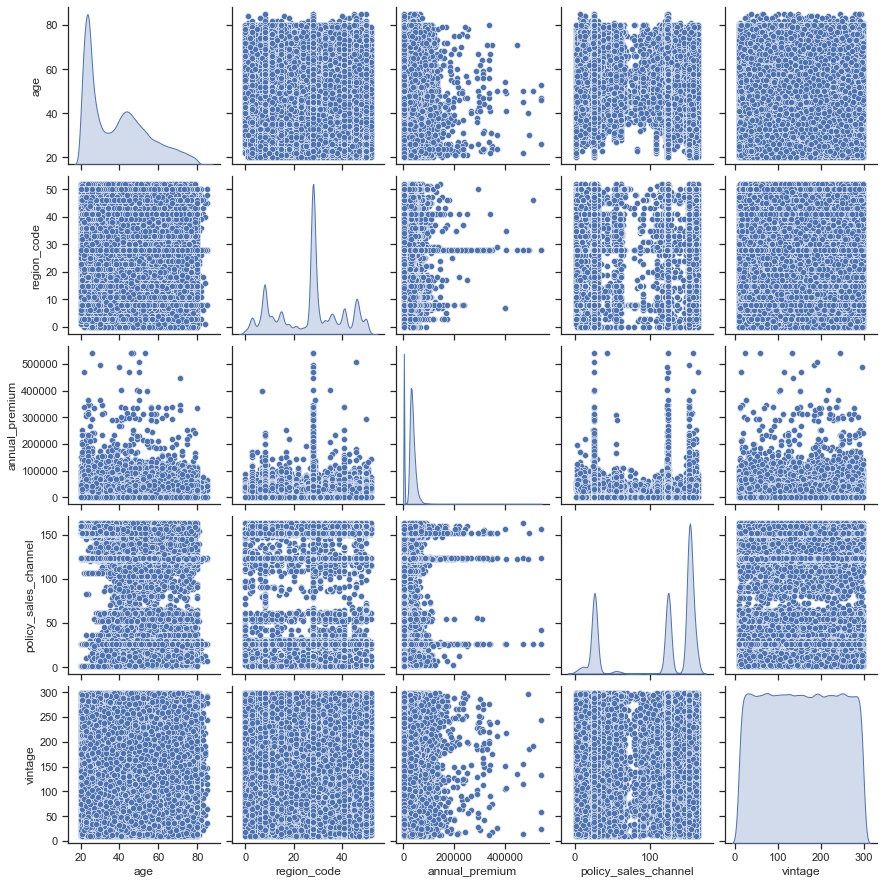

In [24]:
utils.scatterplot_matrix_numeric(dataframe = df1)

# 2.0. Feature Engineering

In [25]:
df2 =  df1.copy()

In [26]:
# vehicle age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' ) 

# vehicle damage
df2['vehicle_damage'] =  df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [27]:
df2.sample(5)

gender  age  driving_license  region_code  previously_insured  \
211567    Male   50                1           28                   1   
471742    Male   56                1           26                   0   
558147  Female   23                1           28                   1   
427976  Female   40                1           28                   0   
406371  Female   27                1           28                   1   

             vehicle_age  vehicle_damage  annual_premium  \
211567  between_1_2_year               0         26911.0   
471742      over_2_years               1         30590.0   
558147      below_1_year               0         54866.0   
427976  between_1_2_year               1         34946.0   
406371      below_1_year               0         28601.0   

        policy_sales_channel  vintage  response  
211567                  26.0      268         0  
471742                 120.0      171         0  
558147                 152.0      266         0  
427976                 124.0      258         0  
406371                 152.0      226         0

# 3.0. Data Filtering

In [28]:
df4 = df2.copy()

# 5.0. Data Preparation

In [29]:
X = df4.drop( 'response', axis=1 )
y = df4['response']

x_train, x_validation, y_train, y_validation = model_selection.train_test_split( X, y, 
                                                                                test_size=0.20,
                                                                                random_state = 42)

df5 = pd.concat( [x_train, y_train], axis=1 )

In [30]:
project_path = Path.cwd().parent
param_root = project_path/'parameters'
if param_root.exists(): 
    print(f'[Info] {param_root} already exists')
else: 
    param_root.mkdir(parents=True, exist_ok = True)
    print(f'[Info] {param_root} was created successfully')

[Info] C:\Users\Windows\Desktop\Repos\insurance_prediction\parameters already exists


## Standardization

In [31]:
ss = pp.StandardScaler()
# annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
trans_path = param_root/'annual_premium_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(ss, file)

## Rescaling

In [32]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )
trans_path = param_root/'age_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(mms_age, file)

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
trans_path = param_root/'vintage_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(mms_vintage, file)

## Encoder

In [33]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
trans_path = param_root/'gender_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(target_encode_gender, file)

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
trans_path = param_root/'region_code_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(target_encode_region_code, file)

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
trans_path = param_root/'policy_sales_channel_transform.pkl'
with open(trans_path, 'wb') as file: 
    pickle.dump(fe_policy_sales_channel, file)

In [34]:
# !zip parameters.zip -r parameters
# !zip models.zip -r models

## 5.4. Validation Preparation

In [35]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

# 6.0. Feature Selection

In [36]:
x_train_n = df5.drop( 'response', axis=1 ).values
y_train_n = y_train.values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	10


In [37]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( 'response', axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

In [38]:
cols_selected_boruta

['age', 'vintage']

## 6.2. Feature Importance

In [39]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( 'response', axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

[Info] Feature ranking:
                        feature  importance
0                       vintage    0.273957
0                annual_premium    0.246204
0                           age    0.165597
0                   region_code    0.103132
0                vehicle_damage    0.068195
0          policy_sales_channel    0.059771
0            previously_insured    0.055856
0      vehicle_age_below_1_year    0.014068
0  vehicle_age_between_1_2_year    0.005746
0                        gender    0.004644
0      vehicle_age_over_2_years    0.002330
0               driving_license    0.000502


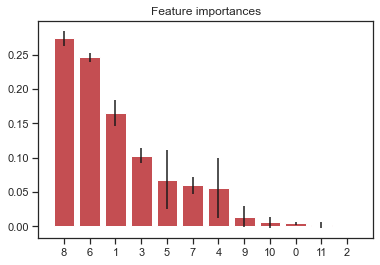

In [40]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("[Info] Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print(df.sort_values( 'importance', ascending=False ))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling

In [41]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

In [42]:
x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

In [43]:
finetuned_parameters = {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 18, 'reg_alpha': 0.01, 'reg_lambda': 0.01}


models = {
    "KNN": KNeighborsClassifier(n_neighbors=7 ),
    "Logistic Regression": LogisticRegression(random_state=42),
#     "Extra Trees": ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42),
#     "Random Forest": RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ),
    "XGBoost": XGBClassifier(), #baseline
    "XGBoost finetuned": XGBClassifier(seed=0, #bayesian finetunning (apparently best model)
                           colsample_bytree = finetuned_parameters['colsample_bytree'], #space_eval(space, best)['colsample_bytree'], 
                           gamma = finetuned_parameters['gamma'],        #space_eval(space, best)['gamma'], 
                           learning_rate = finetuned_parameters['learning_rate'],        #space_eval(space, best)['learning_rate'], 
                           max_depth = finetuned_parameters['max_depth'],        #space_eval(space, best)['max_depth'], 
                           reg_alpha = finetuned_parameters['reg_alpha'],        #space_eval(space, best)['reg_alpha'],
                           reg_lambda = finetuned_parameters['reg_lambda']        #space_eval(space, best)['reg_lambda']
                           )
}


[Info] Path C:\Users\Windows\Desktop\Repos\insurance_prediction\models\figures already exists.
[Info] Path C:\Users\Windows\Desktop\Repos\insurance_prediction\models\models already exists.
[Info] Path C:\Users\Windows\Desktop\Repos\insurance_prediction\models\models created.


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


[Info] KNN results exported successfully


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


[Info] Logistic Regression results exported successfully


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


[Info] XGBoost results exported successfully


Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.


[Info] XGBoost finetuned results exported successfully


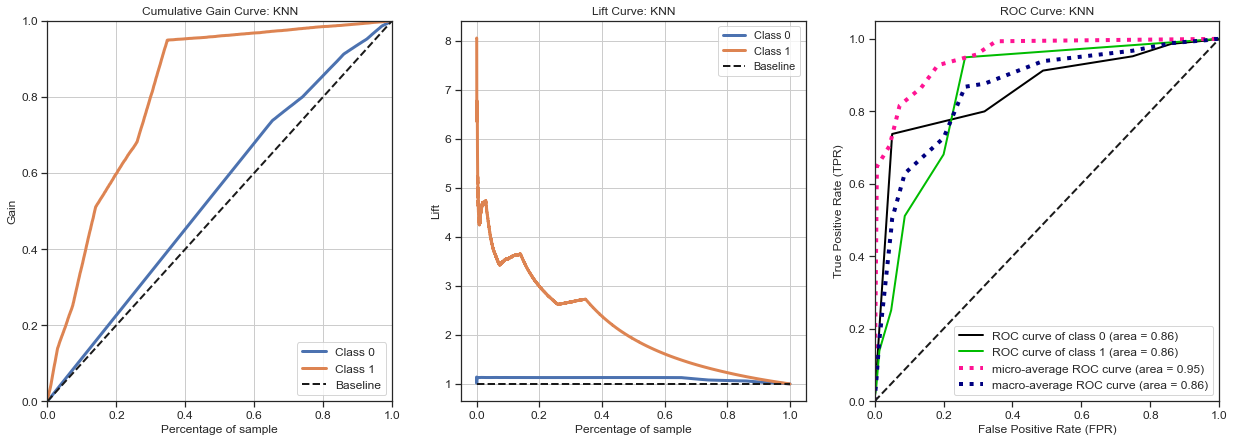

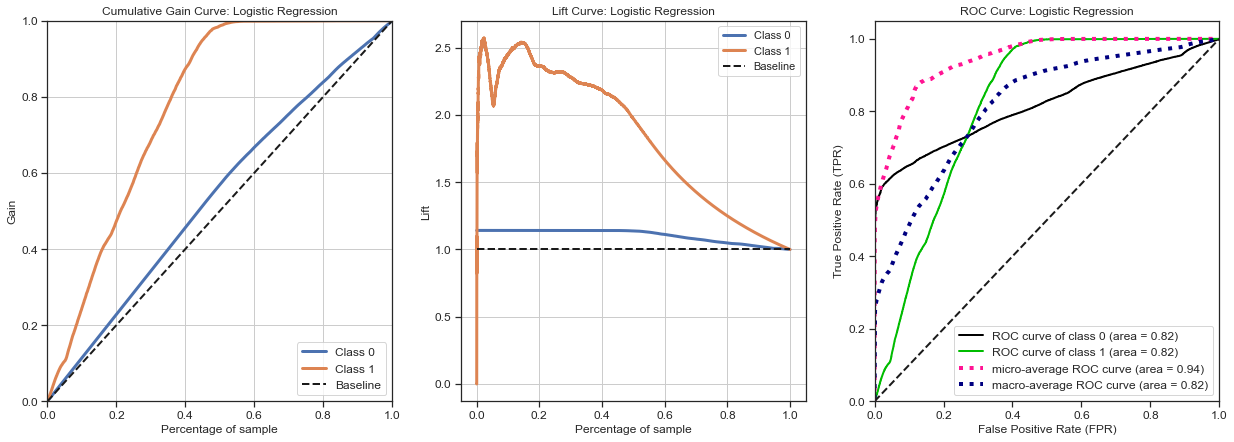

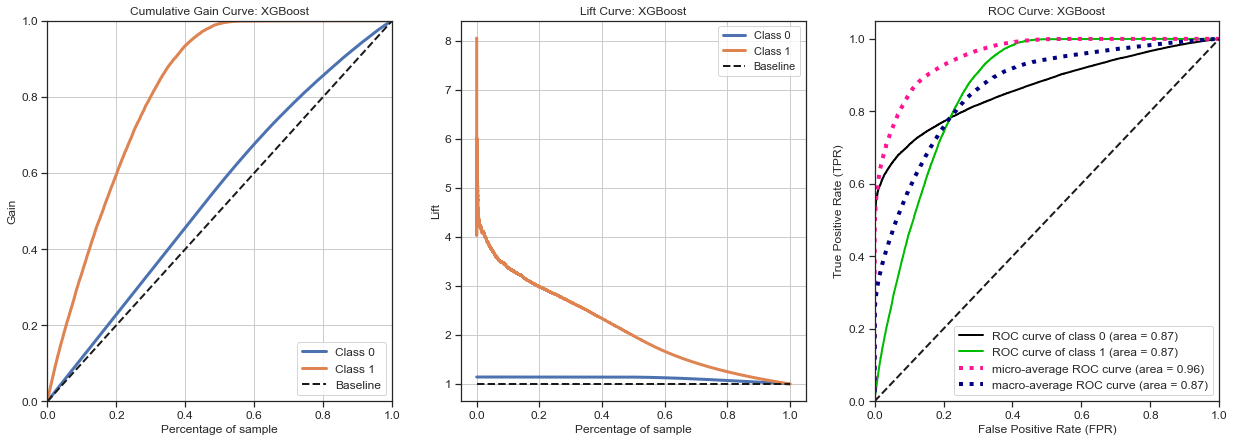

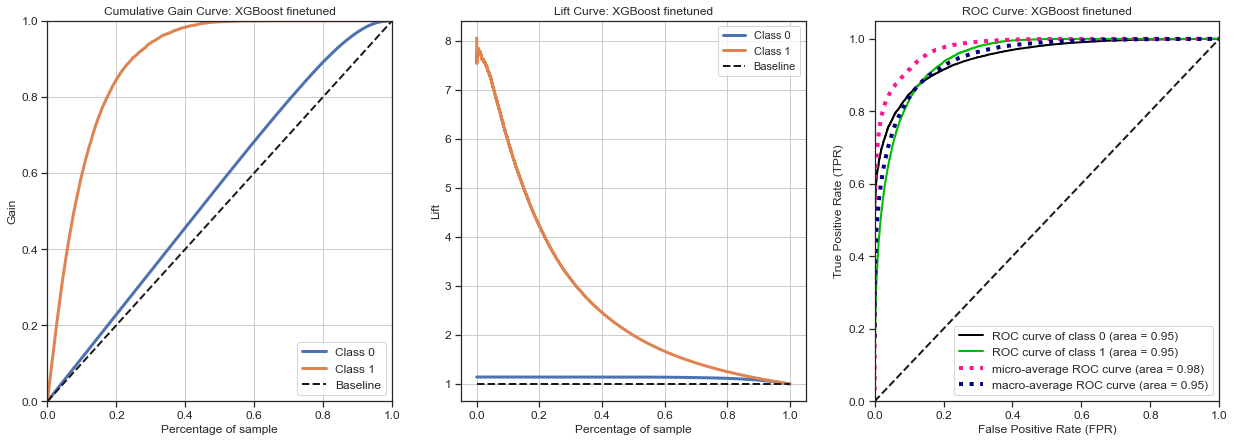

In [44]:
utils.model_assessment(models = models,
                       x_train = x_train, 
                       y_train = y_train,
                       x_test = x_val,
                       y_test = y_val)

### Fine parameter tuning

In [45]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)


# Objective function
def objective(params):
  xgboost = XGBClassifier(seed=0, **params)
  score = cross_val_score(estimator=xgboost, 
                            X=x_train, 
                            y=y_train, 
                            cv=kfold, 
                            scoring='average_precision', 
                            n_jobs=-1).mean()
  # Loss is negative score
  loss = - score
  # Dictionary with information for evaluation
  return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = Trials())

# Print the values of the best parameters
print(space_eval(space, best))

100%|██████████| 48/48 [2:21:24<00:00, 176.76s/trial, best loss: -0.6750070918675023]  
{'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 1, 'max_depth': 18, 'reg_alpha': 1, 'reg_lambda': 1e-05}


In [46]:
final_model = joblib.load('../models/models/xgboost_finetuned.pkl')

In [47]:
explainer = shap.Explainer(final_model)
shap_values = explainer(x_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [48]:
project_path = Path.cwd().parent
shap_root = project_path/'SHAP'
if shap_root.exists(): 
    print(f'[Info] {shap_root} already exists')
else: 
    shap_root.mkdir(parents=True, exist_ok = True)
    print(f'[Info] {shap_root} was created successfully')

[Info] C:\Users\Windows\Desktop\Repos\insurance_prediction\SHAP already exists


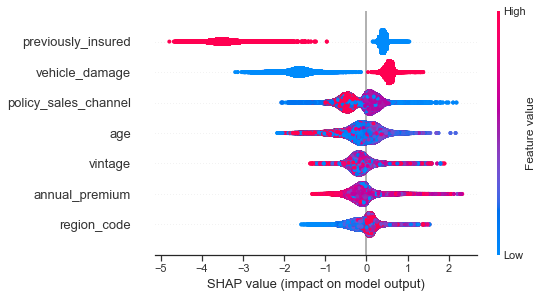

In [49]:
shap.summary_plot(shap_values, x_train,show=False)
plt.gcf().savefig(shap_root/'summary_plot.png',format = "png",dpi = 150,bbox_inches = 'tight')

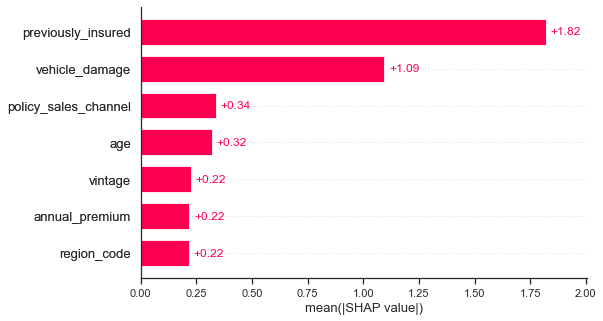

In [50]:
shap.plots.bar(shap_values,show=False)
plt.gcf().savefig(shap_root/'plots.png',format = "png",dpi = 150,bbox_inches = 'tight')

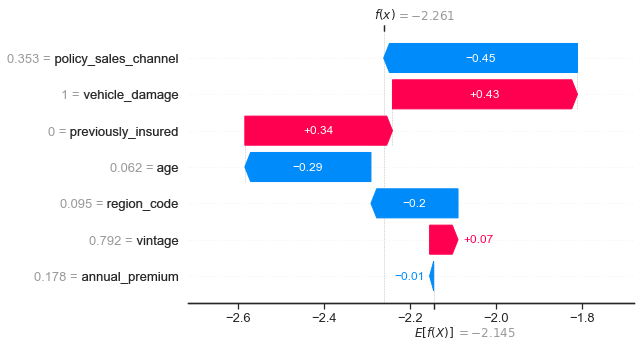

In [54]:
shap.plots.waterfall(shap_values[10],show=False)
plt.gcf().savefig(shap_root/'waterfall.png',format = "png",dpi = 150,bbox_inches = 'tight')

In [59]:
f=shap.plots.force(shap_values.sample(1000))
# shap.force_plot(explainer.expected_value, shap_values, x_train, show=False)
shap.save_html('../SHAP/force.htm', f)

# Testing the class 

In [3]:
creds, _ = utils.load_credentials()
query = """
   SELECT * FROM insurance
   
"""

df_raw = utils.getting_data_from_AWS_RDS(query = query,
                                         host = creds['host'],  
                                         port = creds['port'],  
                                         database = creds['database'], 
                                         user = creds['user'],
                                         password = creds['password'])

[Info] Data Frame with 762218 rows and 11 columns imported successfully.


In [4]:
from InsuranceClass.HealthInsuranceClass import HealthInsurance
test = HealthInsurance()

In [5]:
_ ,creds = utils.load_credentials()

utils.upload_class_data_AWS_S3(df = df_raw,  
                               model_name = 'xgboost_finetuned',
                               aws_update = True, 
                               aws_access_key_id = creds['aws_access_key_id'], 
                               aws_secret_access_key = creds['aws_secret_access_key'],
                               testing_class = test,
                               bucket = 'insurance-data')

Uploaded 762218 rows and 10 columns to s3://insurance-data/data_versions/2023/5/21/data_raw.csv
[Info] raw data created
Uploaded 762218 rows and 10 columns to s3://insurance-data/data_versions/2023/5/21/data_cleaning.csv
[Info] data_cleaning method applied
Uploaded 762218 rows and 10 columns to s3://insurance-data/data_versions/2023/5/21/feature_engineering.csv
[Info] feature_enginerring method applied
Uploaded 762218 rows and 7 columns to s3://insurance-data/data_versions/2023/5/21/data_preparation.csv
[Info] data_preparation method applied
Uploaded 762218 rows and 11 columns to s3://insurance-data/data_versions/2023/5/21/prediction_xgboost_finetuned.csv
[Info] prediction method applied


gender   age  driving_license  region_code  previously_insured  \
0       Female  21.0              1.0         17.0                 1.0   
1         Male  25.0              1.0         11.0                 1.0   
2         Male  34.0              1.0         29.0                 0.0   
3         Male  30.0              1.0         37.0                 0.0   
4       Female  28.0              1.0         52.0                 1.0   
...        ...   ...              ...          ...                 ...   
762213    Male  21.0              1.0         32.0                 1.0   
762214    Male  51.0              1.0         41.0                 0.0   
762215  Female  30.0              1.0         28.0                 0.0   
762216    Male  52.0              1.0         18.0                 0.0   
762217  Female  26.0              1.0         28.0                 1.0   

       vehicle_age vehicle_damage  annual_premium  policy_sales_channel  \
0         < 1 Year             No         33255.0                 160.0   
1         < 1 Year             No         41600.0                 152.0   
2         1-2 Year            Yes         31007.0                 124.0   
3         1-2 Year            Yes          2630.0                 155.0   
4         < 1 Year             No         28718.0                 152.0   
...            ...            ...             ...                   ...   
762213    < 1 Year             No         31451.0                 152.0   
762214    1-2 Year            Yes         30476.0                  26.0   
762215    1-2 Year            Yes         68115.0                 154.0   
762216    < 1 Year            Yes         39082.0                 124.0   
762217    < 1 Year             No         44352.0                 152.0   

        vintage     score  
0          69.0  0.999820  
1         205.0  0.999633  
2         272.0  0.703935  
3          19.0  0.844661  
4          68.0  0.999872  
...         ...       ...  
762213    285.0  0.999804  
762214    167.0  0.836609  
762215     24.0  0.389872  
762216    230.0  0.397562  
762217    252.0  0.999748  

[762218 rows x 11 columns]

# Testing API locally and deployed

In [6]:
creds, _ = utils.load_credentials()
query = """
   SELECT * FROM insurance
   limit 100
"""

df_raw = utils.getting_data_from_AWS_RDS(query = query,
                                         host = creds['host'],  
                                         port = creds['port'],  
                                         database = creds['database'], 
                                         user = creds['user'],
                                         password = creds['password'])

[Info] Data Frame with 100 rows and 11 columns imported successfully.


In [7]:
data = json.dumps(df_raw.drop('response', axis = 1).to_dict( orient='records' ))


# url = 'https:0.0.0.0:8000/predict'
url = 'https://health-insurance-api-oanp.onrender.com/predict'

# API Call
header = {'Content-type': 'application/json' }
r = requests.post( url, data=data, headers=header )
print( f'[Info] Status Code {r.status_code}' )

pd.DataFrame(json.loads(r.json()))

[Info] Status Code 200


gender  age  driving_license  region_code  previously_insured vehicle_age  \
0   Female   21                1           17                   1    < 1 Year   
1     Male   25                1           11                   1    < 1 Year   
2     Male   34                1           29                   0    1-2 Year   
3     Male   30                1           37                   0    1-2 Year   
4   Female   28                1           52                   1    < 1 Year   
..     ...  ...              ...          ...                 ...         ...   
95    Male   37                1           41                   0    1-2 Year   
96  Female   25                1           13                   1    < 1 Year   
97  Female   80                1           28                   0    1-2 Year   
98  Female   24                1            8                   1    < 1 Year   
99    Male   57                1           28                   0    1-2 Year   

   vehicle_damage  annual_premium  policy_sales_channel  vintage     score  
0              No           33255                   160       69  0.999868  
1              No           41600                   152      205  0.999790  
2             Yes           31007                   124      272  0.711825  
3             Yes            2630                   155       19  0.717662  
4              No           28718                   152       68  0.999893  
..            ...             ...                   ...      ...       ...  
95            Yes           43831                    12      254  0.898635  
96             No           34119                   152      224  0.999717  
97            Yes           54905                   122       92  0.975087  
98             No           40550                   152      124  0.999756  
99            Yes           62688                   124      224  0.825549  

[100 rows x 11 columns]

Yeeeiiii :) 